In [ ]:
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.7 MB/s eta 0:00:00


## Impirt require libaries

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import optuna
from optuna.trial import TrialState

from tqdm.auto import tqdm
from timeit import default_timer as timer

In [ ]:
!pip install -q torchmetrics
from torchmetrics.classification import MulticlassAccuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.7 MB/s eta 0:00:00


## Device Agnostic code

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Load Data

In [ ]:
transform = transforms.Compose([
                                transforms.Resize((64, 64)),
                                transforms.ToTensor(),
                              ])

In [ ]:
train_dataset = datasets.FashionMNIST(root = '/data', train = True, transform = transform, download = True)
test_dataset = datasets.FashionMNIST(root = '/data', train = False, transform = transform, download = True)

100%|██████████| 26421880/26421880 [00:01<00:00, 16149475.19it/s]


Extracting /data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271240.29it/s]


Extracting /data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5011425.10it/s]


Extracting /data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13149985.99it/s]

Extracting /data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /data/FashionMNIST/raw



In [ ]:
len(train_dataset), len(test_dataset)

(60000, 10000)

## Make DataLoader

In [ ]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
print(f'Total {len(train_dataloader)} of train each of {BATCH_SIZE} batches.')
print(f'Total {len(test_dataloader)} of test each of {BATCH_SIZE} batches.')

Total 1875 of train each of 32 batches.
Total 313 of test each of 32 batches.


In [ ]:
# class name
class_names = train_dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
index_cls = train_dataset.class_to_idx
index_cls

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

Image: torch.Size([1, 64, 64])


Text(0.5, 1.0, 'Coat')

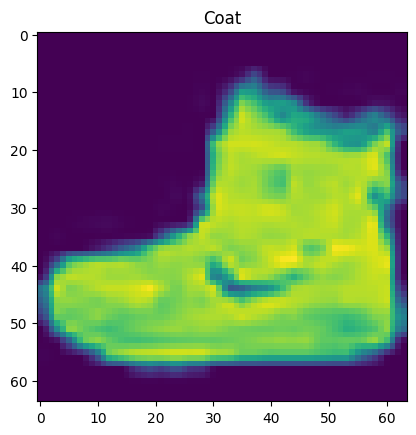

In [ ]:
image, label = train_dataset[0]
print(f"Image: {image.shape}")
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label//2])
# image

## train and test loop

In [ ]:
# train
def train_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
               accuracy_fn, device: torch.device = device):
  
  train_loss, train_acc = 0, 0

  model.train()

  for batch, (x_train, y_train) in enumerate(dataloader):

    if device == 'cuda':
      x_train, y_train = x_train.to(device), y_train.to(device)
    

    # 1. Forward step
    # print("image: ",type(x_train))
    pred = model(x_train)

    # 2. Loss
    loss = loss_fn(pred, y_train)

    # 3. Grad zerostep
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # print(torch.argmax(pred, dim=1))
    
    # print(y_train)

    # print(torch.argmax(pred, dim=0))
    acc = accuracy_fn(y_train, torch.argmax(pred, dim=1))
    train_loss += loss
    train_acc += acc

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


# test
def test_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, accuracy_fn, 
              device: torch.device = device):
  
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for x_test, y_test in dataloader:
      
      if device == 'cuda':
        x_test, y_test = x_test.to(device), y_test.to(device)

      # 1. Forward
      test_pred = model(x_test)
      
      # 2. Loss and accuray
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, torch.argmax(test_pred, dim=1))


    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

## Loss and accuracy Function

In [ ]:
loss_fn = nn.CrossEntropyLoss()

accuracy_fn = MulticlassAccuracy(num_classes = len(class_names)).to(device)

## Build model

In [ ]:
class CustomCNN(nn.Module):
    """CNN for the MNIST dataset of handwritten digits.
    Attributes:
        - convs (torch.nn.modules.container.ModuleList):   List with the convolutional layers
        - conv2_drop (torch.nn.modules.dropout.Dropout2d): Dropout for conv layer 2
        - out_feature (int):                               Size of flattened features
        - fc1 (torch.nn.modules.linear.Linear):            Fully Connected layer 1
        - fc2 (torch.nn.modules.linear.Linear):            Fully Connected layer 2
        - p1 (float):                                      Dropout ratio for FC1
    Methods:
        - forward(x): Does forward propagation
    """
    def __init__(self, trial, num_conv_layers, num_filters, num_neurons, drop_conv2, drop_fc1):
        """Parameters:
            - trial (optuna.trial._trial.Trial): Optuna trial
            - num_conv_layers (int):             Number of convolutional layers
            - num_filters (list):                Number of filters of conv layers
            - num_neurons (int):                 Number of neurons of FC layers
            - drop_conv2 (float):                Dropout ratio for conv layer 2
            - drop_fc1 (float):                  Dropout ratio for FC1
        """
        super().__init__()                                                     # Initialize parent class
        in_size = 32                                                                    # Input image size (28 pixels)
        kernel_size = 3                                                                 # Convolution filter size

        # # Define the convolutional layers
        # self.convs = nn.ModuleList([nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(3, 3), padding = 1, stride = 1)])  # List with the Conv layers
        # out_size = in_size - kernel_size + 1                                            # Size of the output kernel
        # out_size = int(out_size / 2)                                                    # Size after pooling
        # for i in range(1, num_conv_layers):
        #     self.convs.append(nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=(3, 3), padding = 1, stride = 1))
        #     out_size = out_size - kernel_size + 1                                       # Size of the output kernel
        #     out_size = int(out_size/2)                                                  # Size after pooling

        self.conv2_drop = nn.Dropout2d(p=drop_conv2)                                    # Dropout for conv2
        self.out_feature = num_filters * 64 * 64 # out_size         # Size of flattened features
        
        layers = []

        for i in range(num_conv_layers):
          if i == 0:
            layers.append(nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(3, 3), padding = 1, stride = 1))
            layers.append(nn.ReLU()) 

          else:
            if i%2 == 0:
              layers.append(nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=(3, 3), padding = 1, stride = 1))
              layers.append(nn.ReLU())
              layers.append(nn.MaxPool2d(kernel_size = (3,3), stride = 1, padding = 1))

            else:
              layers.append(nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=(3, 3), padding = 1, stride = 1))
              layers.append(nn.ReLU())

        self.cnn_layer = nn.Sequential(*layers)
        
        # print(self.cnn_layer)
        self.fc1 = nn.Sequential(
                                  nn.Flatten(),
                                  nn.Linear(self.out_feature, num_neurons),                            # Fully Connected layer 1
                                  nn.ReLU(),
                                  nn.Linear(num_neurons, 10)                                           # Fully Connected layer 2
                                )# self.p1 = drop_fc1                                                  # Dropout ratio for FC1


    def forward(self, x):
        """Forward propagation.
        Parameters:
            - x (torch.Tensor): Input tensor of size [N,1,28,28]
        Returns:
            - (torch.Tensor): The output tensor after forward propagation [N,10]
        # """
        # for i, conv_i in enumerate(self.convs):  # For each convolutional layer
            # # print("x: ", type(x))
            # if i == 2:  # Add dropout if layer 2
            #     x = F.relu(F.max_pool2d(self.conv2_drop(conv_i(x)), 2))  # Conv_i, dropout, max-pooling, RelU
            # else:
            #     x = F.relu(F.max_pool2d(conv_i(x), 2)) 



        x = self.cnn_layer(x)
        # print("x: ", x.shape, x.shape[-1], )




        # self.out_feature = x.shape[-1] * x.shape[-2] * x.shape[-3]



        x = self.fc1(x) # x.view(-1, self.out_feature)                     # Flatten tensor




        # x = F.relu(self.fc1(x))                              # FC1, RelU
        # x = F.dropout(x, p=self.p1, training=self.training)  # Apply dropout after FC1 only when training
        # x = self.fc2(x)                                      # FC2

        return x # F.log_softmax(x, dim=1)                       # log(softmax(x))

In [ ]:
def objective(trial, n_trials=100):
    """Objective function to be optimized by Optuna.
    Hyperparameters chosen to be optimized: optimizer, learning rate,
    dropout values, number of convolutional layers, number of filters of
    convolutional layers, number of neurons of fully connected layers.
    Inputs:
        - trial (optuna.trial._trial.Trial): Optuna trial
    Returns:
        - accuracy(torch.Tensor): The test accuracy. Parameter to be maximized.
    """

    # Define range of values to be tested for the hyperparameters
    num_conv_layers = trial.suggest_int("num_conv_layers", 3, 6)  # Number of convolutional layers
 

    # Generate the model
    model = CustomCNN(trial, num_conv_layers, num_filters = 10, num_neurons = 512, drop_conv2 = 0.2,  drop_fc1 = 0.2).to(device)


    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)                                 # Learning rates
    n_epochs = trial.suggest_int('n_estimators', 10, 50)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)# getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Training of the model
    for epoch in range(n_epochs):
        train_loss, train_acc = train_loop(model, train_dataloader, loss_fn, optimizer,
                                            accuracy_fn, device = device)  # Train the model
        test_loss, test_acc = test_loop(model, test_dataloader, loss_fn, accuracy_fn, device = device)   # Evaluate the model

        # For pruning (stops trial early if not promising)
        trial.report(test_acc, epoch)
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return test_acc

In [ ]:
# Create an Optuna study to maximize test accuracy
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-04-20 16:49:59,472] A new study created in memory with name: no-name-eeeb51af-3136-4286-98f0-7ca257c6445e
[I 2023-04-20 17:17:57,833] Trial 0 finished with value: 0.888070285320282 and parameters: {'num_conv_layers': 3, 'lr': 0.00033546059758267447, 'n_estimators': 40}. Best is trial 0 with value: 0.888070285320282.
[I 2023-04-20 17:49:56,911] Trial 1 finished with value: 0.8627644777297974 and parameters: {'num_conv_layers': 3, 'lr': 0.0036135083776617353, 'n_estimators': 46}. Best is trial 0 with value: 0.888070285320282.
[I 2023-04-20 18:20:31,217] Trial 2 finished with value: 0.009994011372327805 and parameters: {'num_conv_layers': 4, 'lr': 0.008394378908078872, 'n_estimators': 41}. Best is trial 0 with value: 0.888070285320282.
[I 2023-04-20 19:00:48,089] Trial 3 finished with value: 0.8790345191955566 and parameters: {'num_conv_layers': 6, 'lr': 0.00023572177373420625, 'n_estimators': 48}. Best is trial 0 with value: 0.888070285320282.


In [ ]:
# Find number of pruned and completed trials
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# Display the study statistics
print("\nStudy statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

trial = study.best_trial
print("Best trial:")
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))